<h1 align=center><font size = 5>Segmenting, Clustering and Comparing Neighborhoods from  New York City and London</font></h1>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [60]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from unidecode import unidecode

from lxml import html

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

#### Load and explore the data

In [61]:
newyork_data = requests.get("https://cocl.us/new_york_dataset").json()
print('Data downloaded!')

Data downloaded!


All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [62]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [63]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [64]:
# define the dataframe columns
column_names = ['borough', 'neighborhood', 'latitude', 'longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [65]:
neighborhoods

,borough,neighborhood,latitude,longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [66]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'borough': borough,
                                          'neighborhood': neighborhood_name,
                                          'latitude': neighborhood_lat,
                                          'longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [67]:
neighborhoods.head()

,borough,neighborhood,latitude,longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [68]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [69]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [70]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['latitude'], neighborhoods['longitude'], neighborhoods['borough'], neighborhoods['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [71]:
manhattan_data = neighborhoods[neighborhoods['borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,borough,neighborhood,latitude,longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [72]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


As we did with all of New York City, let's visualizat Manhattan the neighborhoods in it.

In [73]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['latitude'], manhattan_data['longitude'], manhattan_data['neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [74]:
CLIENT_ID = 'DIYWYUU01DTOW5MNJOI32ZMRIGNNO0VAKTDABYYWSKTFK0W1' # your Foursquare ID
CLIENT_SECRET = 'JNND0D0O1Y0GNWDSZAEUFR4IUILFI14CKIJLMGVEURCNKR2V' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DIYWYUU01DTOW5MNJOI32ZMRIGNNO0VAKTDABYYWSKTFK0W1
CLIENT_SECRET:JNND0D0O1Y0GNWDSZAEUFR4IUILFI14CKIJLMGVEURCNKR2V


In [75]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood_latitude', 
                  'neighborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [76]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_data['neighborhood'],
                                   latitudes=manhattan_data['latitude'],
                                   longitudes=manhattan_data['longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Let's check the size of the resulting dataframe

In [77]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3172, 7)


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


Let's check how many venues were returned for each neighborhood

In [78]:
manhattan_venues.groupby('neighborhood').count()

,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
neighborhood,,,,,,
Battery Park City,73,73,73,73,73,73
Carnegie Hill,86,86,86,86,86,86
Central Harlem,44,44,44,44,44,44
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,43,43,43,43,43,43
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [79]:
print('There are {} uniques categories.'.format(len(manhattan_venues['venue_category'].unique())))

There are 326 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [80]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['neighborhood'] = manhattan_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Resta

And let's examine the new dataframe size.

In [81]:
manhattan_onehot.shape

(3172, 327)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [82]:
manhattan_grouped = manhattan_onehot.groupby('neighborhood').mean().reset_index()
manhattan_grouped

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Resta

#### Let's confirm the new size

In [83]:
manhattan_grouped.shape

(40, 327)

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [85]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = manhattan_grouped['neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Shopping Mall,Memorial Site,Gourmet Shop,Playground,Plaza,Sandwich Place
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Bookstore,Wine Shop,Pizza Place,Gym,Gym / Fitness Center,Cosmetics Shop,French Restaurant
2,Central Harlem,African Restaurant,French Restaurant,Seafood Restaurant,Bar,Chinese Restaurant,Cosmetics Shop,American Restaurant,Café,Grocery Store,Event Space
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Seafood Restaurant,Italian Restaurant,Hotel,Bakery,Ice Cream Shop,Nightclub,French Restaurant
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Optical Shop,Salon / Barbershop,Spa,American Restaurant,Dessert Shop,Sandwich Place


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

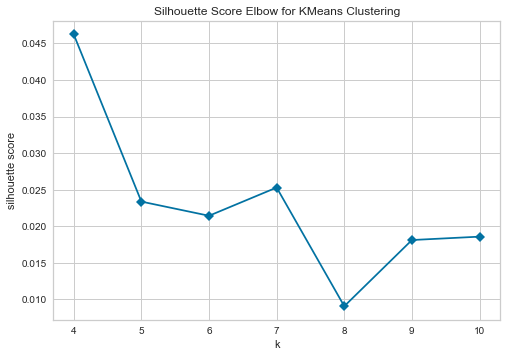

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [86]:
from yellowbrick.cluster import KElbowVisualizer

manhattan_part_clustering = manhattan_grouped.drop('neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(4,11), metric='silhouette', timings=False)

visualizer.fit(manhattan_part_clustering)        # Fit the data to the visualizer
visualizer.poof()    

In [87]:
# set number of clusters
kclusters = 4

manhattan_grouped_clustering = manhattan_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 0, 1, 1, 1, 3, 0, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [88]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')

manhattan_merged.head() # check the last columns!

,borough,neighborhood,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Coffee Shop,Discount Store,Gym,Yoga Studio,Big Box Store,Seafood Restaurant,Tennis Stadium,Supplement Shop,Sandwich Place,Steakhouse
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Optical Shop,Salon / Barbershop,Spa,American Restaurant,Dessert Shop,Sandwich Place
2,Manhattan,Washington Heights,40.851903,-73.936900,3,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Bank,Supermarket,Coffee Shop,Spanish Restaurant,Park,Deli / Bodega
3,Manhattan,Inwood,40.867684,-73.921210,3,Mexican Restaurant,Café,Lounge,Restaurant,Spanish Restaurant,Frozen Yogurt Shop,Park,Bakery,Caribbean Restaurant,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,3,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Park,Bakery,Sandwich Place,Yoga Studio


Finally, let's visualize the resulting clusters

In [89]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['latitude'], manhattan_merged['longitude'], manhattan_merged['neighborhood'], manhattan_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [90]:
manhattan_merged.loc[manhattan_merged['cluster_labels'] == 0, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,0,Coffee Shop,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Bar,Climbing Gym,Cuban Restaurant,Scenic Lookout,Japanese Curry Restaurant
8,Upper East Side,0,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center,Yoga Studio,Pizza Place,Spa,French Restaurant,Juice Bar,Exhibit
9,Yorkville,0,Italian Restaurant,Gym,Bar,Coffee Shop,Sushi Restaurant,Diner,Pizza Place,Japanese Restaurant,Mexican Restaurant,Wine Shop
10,Lenox Hill,0,Coffee Shop,Sushi Restaurant,Pizza Place,Italian Restaurant,Cocktail Bar,Café,Gym / Fitness Center,Gym,Burger Joint,Salon / Barbershop
12,Upper West Side,0,Italian Restaurant,Coffee Shop,Indian Restaurant,Wine Bar,Bakery,Mediterranean Restaurant,Bar,Seafood Restaurant,Thai Restaurant,Ice Cream Shop
17,Chelsea,0,Coffee Shop,Art Gallery,American Restaurant,Seafood Restaurant,Italian Restaurant,Hotel,Bakery,Ice Cream Shop,Nightclub,French Restaurant
18,Greenwich Village,0,Italian Restaurant,Sushi Restaurant,Café,Clothing Store,Indian Restaurant,Gym,Ice Cream Shop,Chinese Restaurant,Gourmet Shop,Dessert Shop
19,East Village,0,Bar,Mexican Restaurant,Ice Cream Shop,Wine Bar,Pizza Place,Cocktail Bar,Vegetarian / Vegan Restaurant,Coffee Shop,Korean Restaurant,Speakeasy
21,Tribeca,0,Park,Italian Restaurant,Wine Bar,Café,Spa,American Restaurant,Coffee Shop,Greek Restaurant,Poke Place,Basketball Court
22,Little Italy,0,Bakery,Italian Restaurant,Bubble Tea Shop,Café,Coffee Shop,Chinese Restaurant,Pizza Place,Hotel,Mediterranean Restaurant,Ice Cream Shop


#### Cluster 2

In [91]:
manhattan_merged.loc[manhattan_merged['cluster_labels'] == 1, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,1,Coffee Shop,Discount Store,Gym,Yoga Studio,Big Box Store,Seafood Restaurant,Tennis Stadium,Supplement Shop,Sandwich Place,Steakhouse
1,Chinatown,1,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Optical Shop,Salon / Barbershop,Spa,American Restaurant,Dessert Shop,Sandwich Place
6,Central Harlem,1,African Restaurant,French Restaurant,Seafood Restaurant,Bar,Chinese Restaurant,Cosmetics Shop,American Restaurant,Café,Grocery Store,Event Space
13,Lincoln Square,1,Plaza,Theater,Italian Restaurant,Gym / Fitness Center,Concert Hall,Performing Arts Venue,Café,Indie Movie Theater,Wine Shop,Clothing Store
14,Clinton,1,Gym / Fitness Center,Theater,Cocktail Bar,American Restaurant,Sandwich Place,Italian Restaurant,Coffee Shop,Gym,Spa,Hotel
15,Midtown,1,Coffee Shop,Hotel,Clothing Store,Theater,Sporting Goods Shop,Bakery,Bookstore,Steakhouse,Sandwich Place,Sushi Restaurant
16,Murray Hill,1,Sandwich Place,Coffee Shop,American Restaurant,Japanese Restaurant,Bar,Hotel,Gym / Fitness Center,Pizza Place,Burger Joint,Jewish Restaurant
20,Lower East Side,1,Coffee Shop,Cocktail Bar,Bakery,Café,Chinese Restaurant,Art Gallery,Japanese Restaurant,Mediterranean Restaurant,Bubble Tea Shop,Diner
29,Financial District,1,Coffee Shop,Pizza Place,Café,Cocktail Bar,Steakhouse,Gym / Fitness Center,Italian Restaurant,Gym,Park,American Restaurant
30,Carnegie Hill,1,Coffee Shop,Café,Yoga Studio,Bookstore,Wine Shop,Pizza Place,Gym,Gym / Fitness Center,Cosmetics Shop,French Restaurant


#### Cluster 3

In [92]:
manhattan_merged.loc[manhattan_merged['cluster_labels'] == 2, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,2,Park,Bar,Baseball Field,Pet Service,Gas Station,Boat or Ferry,Bistro,Farmers Market,Gym / Fitness Center,Cocktail Bar


#### Cluster 4

In [93]:
manhattan_merged.loc[manhattan_merged['cluster_labels'] == 3, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,3,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Bank,Supermarket,Coffee Shop,Spanish Restaurant,Park,Deli / Bodega
3,Inwood,3,Mexican Restaurant,Café,Lounge,Restaurant,Spanish Restaurant,Frozen Yogurt Shop,Park,Bakery,Caribbean Restaurant,Chinese Restaurant
4,Hamilton Heights,3,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Park,Bakery,Sandwich Place,Yoga Studio
7,East Harlem,3,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Sandwich Place,Latin American Restaurant,Pizza Place,Grocery Store,Seafood Restaurant,Liquor Store
11,Roosevelt Island,3,Park,Monument / Landmark,Farmers Market,Liquor Store,Greek Restaurant,Metro Station,Supermarket,Bubble Tea Shop,Bus Line,Food & Drink Shop
26,Morningside Heights,3,Park,Coffee Shop,Bookstore,American Restaurant,Burger Joint,Deli / Bodega,Sandwich Place,Mediterranean Restaurant,Supermarket,Mexican Restaurant
28,Battery Park City,3,Park,Hotel,Coffee Shop,Gym,Shopping Mall,Memorial Site,Gourmet Shop,Playground,Plaza,Sandwich Place
36,Tudor City,3,Park,Mexican Restaurant,Café,Coffee Shop,Deli / Bodega,Diner,Spanish Restaurant,Sushi Restaurant,Garden,Gym


<a id='item1'></a>

# London

London is compsosed of 32 boroughs plus the City of London that are grouped in 5 sub-regions. Each borough is composed of a few "areas" which are equivalent to the neighborhoods in New York City. So in order to create a similar dataset I will collect data from two wikipedia pages and combine the results.

In [94]:
url_areas = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
url_regions = 'https://en.wikipedia.org/wiki/List_of_sub-regions_used_in_the_London_Plan'

session = requests.session()
session.verify = False

resp_areas = session.get(url_areas)
resp_regions = session.get(url_regions)

root_areas = html.fromstring(resp_areas.content)
root_regions = html.fromstring(resp_regions.content)

In [95]:
# Function to extract data from wikipedia tables
def extract_data(root):
    row_combox = root.xpath('.//table[contains(@class, "wikitable")]')
    row_combox = row_combox[0].xpath('.//tbody/tr')
    cols = [unidecode(line.text.strip()).replace(" ", "_").lower() if line.text is not None else None for line in list(row_combox[0])]

    data = []
    for row in row_combox[1:]:
        row_dict = {}
        for col in zip(cols, list(row)):
            row_dict[col[0]] = col[1].text_content().split('[')[0].strip()
        
        data.append(row_dict)
    
    return data

In [96]:
london_areas = extract_data(root_areas)
london_areas = pd.DataFrame(london_areas)
print(london_areas.shape)
london_areas.head()

(533, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


### Data Wrangling 

First, I will modify the london_areas data so there is only one borough per location. The reason for that, is because in order to assign a region to a location, I need to know its borough. Let's use the geopy library to search the location and use the borough it returns. 

Remove parentheses from location  

In [97]:
def remove_parentheses(row):
    location = row['location']
    if '(' in location:
        location = location.split('(')[0].strip()
    return location

In [98]:
london_areas['location'] = london_areas.apply(remove_parentheses, axis=1)
print(london_areas.shape)
london_areas.head()

(533, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Select locations with more than one borough

In [99]:
borough_comma = london_areas.loc[london_areas['london_borough'].str.contains(', | &')]
print(borough_comma.shape)
borough_comma.head()

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,"Redbridge, Barking and Dagenham",ROMFORD,RM6,020,TQ485885
99,Chiswick,"Hounslow, Ealing, Hammersmith and Fulham",LONDON,W4,020,TQ205785
102,Clapham,"Lambeth, Wandsworth",LONDON,SW4,020,TQ295755


In [100]:
def select_neighborhood(row):
    area = row['location']
    borough = row['london_borough']
    nomi = Nominatim(user_agent='london_app')
    result = nomi.geocode(f'{area}, London, United Kingdom')
    
    for line in result[0].split(','):
        if 'Borough of' in line:
            borough = line.split('of')[-1].strip()
            break
        
    return borough

In [101]:
borough_comma.loc[:, 'london_borough'] = borough_comma.apply(select_neighborhood, axis=1)
borough_comma.loc[borough_comma['london_borough'].str.contains(', | &')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
102,Clapham,"Lambeth, Wandsworth",LONDON,SW4,020,TQ295755
121,Cricklewood,"Barnet, Brent, Camden",LONDON,NW2,020,TQ235855
392,Ruxley,"Bexley, Bromley","SIDCUP, ORPINGTON","DA14, BR5","020, 01689",TQ485704
457,Temple,"City, Westminster",LONDON,"EC4, WC2",020,TQ311809
459,Thamesmead,"Bexley, Greenwich","LONDON, ERITH","SE28, SE2, DA18",020,TQ475805
479,Upper Ruxley,"Bexley, Bromley","SIDCUP, ORPINGTON","DA14, BR5","020, 01689",TQ4970


As we can see there are still some locations where it wasn't possible to update the neighborhood using geopy so those I will research online and fix by hand.  

In [102]:
indexes = borough_comma.loc[borough_comma['london_borough'].str.contains(', | &')].index
new_boroughs = ['Lambeth', 'Camden', 'Bromley', 'City', 'Greenwich', 'Bromley']

borough_comma.loc[indexes, 'london_borough'] = new_boroughs
print(borough_comma)
borough_comma

location london_borough                        post_town  \
0        Abbey Wood      Greenwich                           LONDON   
1             Acton         Ealing                           LONDON   
85   Chadwell Heath      Redbridge                          ROMFORD   
99         Chiswick       Hounslow                           LONDON   
102         Clapham        Lambeth                           LONDON   
104     Cockfosters        Enfield                           BARNET   
121     Cricklewood         Camden                           LONDON   
168      Falconwood      Greenwich                  LONDON, WELLING   
169      Farringdon      Islington                           LONDON   
173   Finsbury Park      Islington                           LONDON   
249       Horn Park      Greenwich                           LONDON   
260      Kennington      Southwark                           LONDON   
264          Kenton          Brent                   HARROW, LONDON   
268         Kilbu

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,Redbridge,ROMFORD,RM6,020,TQ485885
99,Chiswick,Hounslow,LONDON,W4,020,TQ205785
102,Clapham,Lambeth,LONDON,SW4,020,TQ295755
104,Cockfosters,Enfield,BARNET,EN4,020,TQ275965
121,Cricklewood,Camden,LONDON,NW2,020,TQ235855
168,Falconwood,Greenwich,"LONDON, WELLING","SE9, DA16",020,TQ455755
169,Farringdon,Islington,LONDON,EC1,020,TQ315818
173,Finsbury Park,Islington,LONDON,N4,020,TQ314872


In [103]:
london_areas.loc[borough_comma.index, 'london_borough'] = borough_comma['london_borough']
print(london_areas.iloc[borough_comma.index].shape)
london_areas.iloc[borough_comma.index].head()

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,Redbridge,ROMFORD,RM6,020,TQ485885
99,Chiswick,Hounslow,LONDON,W4,020,TQ205785
102,Clapham,Lambeth,LONDON,SW4,020,TQ295755


Convert OS Grid (British National Grid References) to Latitude & Longitude

In [104]:
 from OSGridConverter import grid2latlong

def grid_conversion(row):
    grid = row['os_grid_ref'].strip()
    latitude = None
    longitude = None
    if len(grid):
        coord = grid2latlong(grid)
        latitude = coord.latitude
        longitude = coord.longitude
    
    else:
        nomi = Nominatim(user_agent='london_app')
        location = row['location']
        borough = row['london_borough']
        result = nomi.geocode(f'{location}, {borough}, London, United Kingdom')

        if result is not None:
            latitude = result[1][0]
            longitude = result[1][1]

    return latitude, longitude

In [105]:
london_areas[['latitude', 'longitude']] = ''

london_areas[['latitude', 'longitude']] = london_areas.apply(grid_conversion, axis=1, result_type='expand')
london_areas.head()

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785,51.486484,0.109318
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805,51.510591,-0.264585
2,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.362934,-0.025780
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381625,-0.068126
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.434929,0.125663


Rename borough "City" to "City of London"

In [106]:
london_areas['london_borough'] = london_areas['london_borough'].str.replace('City', 'City of London')
london_areas.head(10)

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785,51.486484,0.109318
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805,51.510591,-0.264585
2,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.362934,-0.025780
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381625,-0.068126
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.434929,0.125663
5,Aldborough Hatch,Redbridge,ILFORD,IG2,020,TQ455895,51.585581,0.099459
6,Aldgate,City of London,LONDON,EC3,020,TQ334813,51.514885,-0.078356
7,Aldwych,Westminster,LONDON,WC2,020,TQ307810,51.512819,-0.117388
8,Alperton,Brent,WEMBLEY,HA0,020,TQ185835,51.537976,-0.292401
9,Anerley,Bromley,LONDON,SE20,020,TQ345695,51.408585,-0.066989


Fix problematic locations

In [107]:
london_areas.loc[(london_areas['location'] == 'Brompton') | (london_areas['location'] == 'Sudbury') | (london_areas['location'] == 'Somerstown')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
68,Brompton,Kensington and ChelseaHammersmith and Fulham,LONDON,SW3,020,TQ275795,51.500069,-0.164056
411,Somerstown,Camden,LONDON,NW1,020,TQ295825,51.526575,-0.134133
448,Sudbury,Newham,"HARROW, WEMBLEY","HA0, HA1",020,TQ165852,51.553670,-0.320682


In [108]:
london_areas.loc[68, 'london_borough'] = 'Kensington and Chelsea'
london_areas.loc[411, 'location'] = 'Somers Town'
london_areas.loc[448, 'london_borough'] = 'Brent'
london_areas.iloc[[68, 411, 448]]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
68,Brompton,Kensington and Chelsea,LONDON,SW3,020,TQ275795,51.500069,-0.164056
411,Somers Town,Camden,LONDON,NW1,020,TQ295825,51.526575,-0.134133
448,Sudbury,Brent,"HARROW, WEMBLEY","HA0, HA1",020,TQ165852,51.553670,-0.320682


Now that we fixed the dataset, let's check if we got 33 unique boroughs, which is London's official number of boroughs.

In [109]:
len(london_areas['london_borough'].unique())

36

We have 3 more boroughs than we should have. In order to find out which ones are wrong, I will download an oficial government dataset containing information about London's boroughs and will compare it with our list.

In [110]:
official_boroughs = pd.read_csv('https://data.london.gov.uk/download/london-borough-profiles/c1693b82-68b1-44ee-beb2-3decf17dc1f8/london-borough-profiles.csv', engine='python')
official_boroughs.head()

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015","Proportion_of_population_aged_65_and_over,_2015",Net_internal_migration_(2015),Net_international_migration_(2015),Net_natural_change_(2015),%_of_resident_population_born_abroad_(2015),Largest_migrant_population_by_country_of_birth_(2011),%_of_largest_migrant_population_(2011),Second_largest_migrant_population_by_country_of_birth_(2011),%_of_second_largest_migrant_population_(2011),Third_largest_migrant_population_by_country_of_birth_(2011),%_of_third_largest_migrant_population_(2011),%_of_population_from_BAME_groups_(2016),%_people_aged_3+_whose_main_language_is_not_English_(2011_Census),"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)","New_migrant_(NINo)_rates,_(2015/16)",Largest_migrant_population_arrived_during_2015/16,Second_largest_migrant_population_arrived_during_2015/16,Third_largest_migrant_population_arrived_during_2015/16,Employment_rate_(%)_(2015),Male_employment_rate_(2015),Female_employment_rate_(2015),Unemployment_rate_(2015),Youth_Unemployment_(claimant)_rate_18-24_(Dec-15),Proportion_of_16-18_year_olds_who_are_NEET_(%)_(2014),Proportion_of_the_working-age_population_who_claim_out-of-work_benefits_(%)_(May-2016),%_working-age_with_a_disability_(2015),Proportion_of_working_age_people_with_no_qualifications_(%)_2015,Proportion_of_working_age_with_degree_or_equivalent_and_above_(%)_2015,"Gross_Annual_Pay,_(2016)",Gross_Annual_Pay_-_Male_(2016),Gross_Annual_Pay_-_Female_(2016),Modelled_Household_median_income_estimates_2012/13,%_adults_that_volunteered_in_past_12_months_(2010/11_to_2012/13),Number_of_jobs_by_workplace_(2014),%_of_employment_that_is_in_public_sector_(2014),"Jobs_Density,_2015","Number_of_active_businesses,_2015",Two-year_business_survival_rates_(started_in_2013),Crime_rates_per_thousand_population_2014/15,Fires_per_thousand_population_(2014),Ambulance_incidents_per_hundred_population_(2014),"Median_House_Price,_2015","Average_Band_D_Council_Tax_charge_(£),_2015/16",New_Homes_(net)_2015/16_(provisional),"Homes_Owned_outright,_(2014)_%","Being_bought_with_mortgage_or_loan,_(2014)_%","Rented_from_Local_Authority_or_Housing_Association,_(2014)_%","Rented_from_Private_landlord,_(2014)_%","%_of_area_that_is_Greenspace,_2005",Total_carbon_emissions_(2014),"Household_Waste_Recycling_Rate,_2014/15","Number_of_cars,_(2011_Census)","Number_of_cars_per_household,_(2011_Census)","%_of_adults_who_cycle_at_least_once_per_month,_2014/15","Average_Public_Transport_Accessibility_score,_2014","Achievement_of_5_or_more_A*-_C_grades_at_GCSE_or_equivalent_including_English_and_Maths,_2013/14",Rates_of_Children_Looked_After_(2016),%_of_pupils_whose_first_language_is_not_English_(2015),%_children_living_in_out-of-work_households_(2015),"Male_life_expectancy,_(2012-14)","Female_life_expectancy,_(2012-14)",Teenage_conception_rate_(2014),Life_satisfaction_score_2011-14_(out_of_10),Worthwhileness_score_2011-14_(out_of_10),Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800,5326,290,30.3,43.2,11.4,73.1,15.5,-7,665,30,.,United States,2.8,France,2,Australia,1.9,27.5,17.1,975,152.2,India,France,United States,64.6,.,.,.,1.6,.,3.4,.,.,.,.,.,.,"£63,620",.,500400,3.4,84.3,26130,64.3,.,12.3,.,799999,931.2,80,.,.,.,.,4.8,1036,34.4,1692,0.4,16.9,7.9,78.6,101,.,7.9,.,.,.,6.6,7.1,6.0,5.6,NaN,2.6,129,.,.,.,.,.
1,E09000002,Barking and Dagenham,Outer London,209000,

In [111]:
official_boroughs.dropna(inplace=True)
official_areas = official_boroughs['Area_name']
official_areas.head()

1    Barking and Dagenham
2                  Barnet
3                  Bexley
4                   Brent
5                 Bromley
Name: Area_name, dtype: object

In [112]:
# Extra boroughs
myareas = pd.Series(london_areas['london_borough'].unique())

myareas.loc[~myareas.isin(official_areas)]

5           City of London
32                Dartford
34    Camden and Islington
35     Haringey and Barnet
dtype: object

Fix problematic boroughs

In [113]:
london_areas.loc[(london_areas['london_borough'] == 'Dartford')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
133,Dartford,Dartford,LONDON,DA5,020,TQ287861,51.55911,-0.144352


In [114]:
london_areas.loc[133, 'london_borough'] = 'Bexley'
london_areas['london_borough'] = london_areas['london_borough'].str.replace('Camden and Islington', 'Camden')
london_areas['london_borough'] = london_areas['london_borough'].str.replace('Haringey and Barnet', 'Haringey')


len(london_areas['london_borough'].unique())

33

In [115]:
# Rename columns
london_areas.rename(columns={'location': 'neighborhood', 'london_borough': 'borough'}, inplace=True)

Now let's collect the assign the locations to its respective regions 

In [116]:
london_regions = extract_data(root_regions)
london_regions = pd.DataFrame(london_regions)
london_regions.head()

,sub-region,london_boroughs,area
0,Central,"Camden, City of London, Kensington and Chelsea...","13,136.02 hectares (50.7185 sq mi)"
1,East,"Barking and Dagenham, Bexley, Greenwich, Hackn...","47,673.77 hectares (184.0695 sq mi)"
2,North,"Barnet, Enfield, Haringey","19,853.67 hectares (76.6554 sq mi)"
3,South,"Bromley, Croydon, Kingston upon Thames, Merton...","44,936.52 hectares (173.5009 sq mi)"
4,West,"Brent, Ealing, Hammersmith and Fulham, Harrow,...","33,868.62 hectares (130.7675 sq mi)"


Spread the dataset

In [117]:
london_regions = pd.DataFrame(london_regions['london_boroughs'].str.split(',').tolist(), index=london_regions['sub-region']).stack()
london_regions = london_regions.reset_index()[['sub-region', 0]]

london_regions = london_regions.apply(lambda x: x.str.strip())

london_regions.rename(columns={'sub-region': 'sub_region', 0: 'borough'}, inplace=True)
london_regions.head()

,sub_region,borough
0,Central,Camden
1,Central,City of London
2,Central,Kensington and Chelsea
3,Central,Islington
4,Central,Lambeth


Now, let's merge the tables

In [118]:
london_data = pd.merge(london_regions, london_areas[['borough', 'neighborhood', 'latitude', 'longitude']], on='borough', how='inner').reset_index(drop=True)
london_data.head()

,sub_region,borough,neighborhood,latitude,longitude
0,Central,Camden,Belsize Park,51.545049,-0.165131
1,Central,Camden,Bloomsbury,51.526345,-0.119715
2,Central,Camden,Camden Town,51.544548,-0.133398
3,Central,Camden,Chalk Farm,51.543969,-0.153628
4,Central,Camden,Cricklewood,51.554879,-0.219592


In [119]:
# Check for nulls 
london_data.isnull().sum()

sub_region      0
borough         0
neighborhood    0
latitude        0
longitude       0
dtype: int64

In [120]:
num_neighborhoods = london_data.shape[0]
num_boroughs = len(london_data['borough'].unique())
print(f'There are {num_boroughs} boroughs and {num_neighborhoods} neighborhoods in London.')

There are 33 boroughs and 533 neighborhoods in London.


Now that the dataset is clean, let's check for duplicates in the coordinates. The reason this wasn't done before is because I wanted to fix the inconsistencies beforehand so I have the correct data to search for the correct coordinates in case I have to fix something.

In [121]:
duplicated_coord = london_data.loc[london_data.duplicated(subset=['latitude', 'longitude'], keep=False)]
duplicated_coord
duplicated_coord.shape

(103, 5)

In [122]:
print(f"There are {duplicated_coord.shape[0]} neighborhoods that have potentially bad coordinates so I will use geopy to search for all of them")

There are 103 neighborhoods that have potentially bad coordinates so I will use geopy to search for all of them


In [123]:
nomi = Nominatim(user_agent='london')
nomi.geocode(f'Bloomsbury, Camden, London, United Kingdom')[1]

(51.523126, -0.1260664)

In [124]:
# Get coordinates 
def get_coordinates(row):
    neighborhood = row['neighborhood'] 
    borough = row['borough']
    nomi = Nominatim(user_agent='london')
    result = nomi.geocode(f'{neighborhood}, {borough}, London, United Kingdom')
    
    latitude = None
    longitude = None
    
    if result is not None:
        latitude = result[1][0]
        longitude = result[1][1]
        
    return latitude, longitude

In [125]:
duplicated_coord[['latitude', 'longitude']] = duplicated_coord.apply(get_coordinates, axis=1, result_type='expand')
duplicated_coord

,sub_region,borough,neighborhood,latitude,longitude
1,Central,Camden,Bloomsbury,51.523126,-0.126066
9,Central,Camden,Highgate,51.574432,-0.152684
10,Central,Camden,Holborn,51.517934,-0.119528
13,Central,Camden,King's Cross,51.532395,-0.123022
16,Central,Camden,St Giles,51.515472,-0.128418
17,Central,Camden,St Pancras,51.532291,-0.125999
25,Central,Kensington and Chelsea,Brompton,51.491822,-0.178326
29,Central,Kensington and Chelsea,Kensington,51.498995,-0.199123
30,Central,Kensington and Chelsea,North Kensington,51.519665,-0.210696
34,Central,Islington,Angel,51.531842,-0.105714


Look for, and fix nulls in the new coordinates if found 

In [126]:
duplicated_coord.loc[duplicated_coord.isnull().any(1)]

,sub_region,borough,neighborhood,latitude,longitude
123,East,Bexley,North End,NaN,NaN
256,East,Waltham Forest,Cann Hall,NaN,NaN


After checking on Google, the original coordinates for those two neighborhoods were correct so I will keep them in the dataset and update the new ones.

In [127]:
index2update = np.setdiff1d(duplicated_coord.index, duplicated_coord.loc[duplicated_coord.isnull().any(1)].index)
london_data.loc[index2update, ['latitude', 'longitude']] = duplicated_coord.loc[index2update, ['latitude', 'longitude']]

print(f"There are {london_data.duplicated(subset=['latitude', 'longitude'], keep=False).sum()} duplicate coordinates left.")

There are 0 duplicate coordinates left.


#### Change the coordinates columns data type

In [128]:
london_data['latitude'] = london_data['latitude'].astype('float64')
london_data['longitude'] = london_data['longitude'].astype('float64')
london_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sub_region    533 non-null    object 
 1   borough       533 non-null    object 
 2   neighborhood  533 non-null    object 
 3   latitude      533 non-null    float64
 4   longitude     533 non-null    float64
dtypes: float64(2), object(3)
memory usage: 20.9+ KB


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>london_explorer</em>, as shown below.

In [129]:
address = 'London, England'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


Encode "sub_region" column

In [130]:
from sklearn import preprocessing

region_encoder = preprocessing.LabelEncoder()
region_encoder.fit(london_data['sub_region'])
region_encoder.classes_

array(['Central', 'East', 'North', 'South', 'West'], dtype=object)

In [131]:
london_data.insert(1, 'sub_region_encoded', region_encoder.transform(london_data['sub_region']))
london_data.head()

,sub_region,sub_region_encoded,borough,neighborhood,latitude,longitude
0,Central,0,Camden,Belsize Park,51.545049,-0.165131
1,Central,0,Camden,Bloomsbury,51.523126,-0.126066
2,Central,0,Camden,Camden Town,51.544548,-0.133398
3,Central,0,Camden,Chalk Farm,51.543969,-0.153628
4,Central,0,Camden,Cricklewood,51.554879,-0.219592


#### Create a map of London with neighborhoods superimposed on top.

In [132]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the sub regions
num_regions = len(london_data['sub_region_encoded'].unique())
# x = np.arange(num_regions)
# ys = [i + x + (i*x)**2 for i in range(num_regions)]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['red', 'blue', 'orange', 'black', 'green']

# add markers to map
for lat, lng, borough, neighborhood, region in zip(london_data['latitude'], london_data['longitude'], london_data['borough'], london_data['neighborhood'], london_data['sub_region_encoded']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[region],
        fill=True,
        fill_color=rainbow[region],
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

However, let's simplify the above map and segment and cluster only the neighborhoods in Central London to Manhattan. So let's slice the original dataframe and create a new dataframe of the Central London data.

In [133]:
london_central = london_data.loc[london_data['sub_region'] == 'Central'].reset_index(drop=True)
london_central.head()
london_central.shape

(95, 6)

As we did with Manhattan, let's visualizat Central London's neighborhood.

In [134]:
print(f'There are {london_central.shape[0]} neighborhoods in Central London')

There are 95 neighborhoods in Central London


In [135]:
# create map of Manhattan using latitude and longitude values from the previous map
map_london_central = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, borough in zip(london_central['latitude'], london_central['longitude'], london_central['neighborhood'], london_central['borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_central)  
    
map_london_central

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## 2. Explore Neighborhoods in London

In [136]:
london_venues = getNearbyVenues(names=london_central['neighborhood'],
                                 latitudes=london_central['latitude'],
                                 longitudes=london_central['longitude']
                                 )

Belsize Park
Bloomsbury
Camden Town
Chalk Farm
Cricklewood
Fitzrovia
Frognal
Gospel Oak
Hampstead
Highgate
Holborn
Kentish Town
Kilburn
King's Cross
Primrose Hill
Somers Town
St Giles
St Pancras
Swiss Cottage
Tufnell Park
West Hampstead
Aldgate
Barbican
Blackfriars
Temple
Brompton
Chelsea
Earls Court
Holland Park
Kensington
North Kensington
Notting Hill
South Kensington
West Brompton
Angel
Archway
Barnsbury
Canonbury
Clerkenwell
De Beauvoir Town
Farringdon
Finsbury
Finsbury Park
Highbury
Holloway
Islington
Nag's Head
Pentonville
St Luke's
Upper Holloway
Brixton
Clapham
Gipsy Hill
Herne Hill
Lambeth
Oval
Stockwell
Streatham
Tulse Hill
Vauxhall
West Norwood
Bankside
Bermondsey
Camberwell
Denmark Hill
Dulwich
East Dulwich
Elephant and Castle
Kennington
Newington
Nunhead
Peckham
Rotherhithe
Surrey Quays
Sydenham Hill
Walworth
Aldwych
Bayswater
Belgravia
Charing Cross
Chinatown
Covent Garden
Knightsbridge
Lisson Grove
Little Venice
Maida Vale
Marylebone
Mayfair
Millbank
Paddington
Pimlico
S

#### Let's check the size of the resulting dataframe

In [137]:
print(london_venues.shape)
london_venues.head()
london_venues.shape

(4954, 7)


(4954, 7)

Let's check how many venues were returned for each neighborhood

In [138]:
london_venues.groupby('neighborhood').count()
london_venues.groupby('neighborhood').count().shape

(95, 6)

#### Let's find out how many unique categories can be curated from all the returned venues

In [139]:
print('There are {} uniques categories.'.format(len(london_venues['venue_category'].unique())))

There are 327 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [140]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['neighborhood'] = london_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()
london_onehot.shape

(4954, 328)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [141]:
london_grouped = london_onehot.groupby('neighborhood').mean().reset_index()
london_grouped.head()
london_grouped.shape

(95, 328)

#### Let's print each neighborhood along with the top 5 most common venues

In [142]:
num_top_venues = 5

for hood in london_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aldgate----
                  venue  freq
0           Coffee Shop  0.09
1                 Hotel  0.06
2  Gym / Fitness Center  0.05
3          Cocktail Bar  0.05
4    Italian Restaurant  0.04


----Aldwych----
          venue  freq
0       Theater  0.09
1   Coffee Shop  0.07
2           Pub  0.06
3         Hotel  0.05
4  Burger Joint  0.05


----Angel----
                  venue  freq
0                   Pub  0.11
1           Coffee Shop  0.06
2                  Café  0.05
3  Gym / Fitness Center  0.05
4   Arts & Crafts Store  0.03


----Archway----
           venue  freq
0    Coffee Shop  0.14
1  Grocery Store  0.14
2            Pub  0.11
3    Pizza Place  0.08
4           Café  0.08


----Bankside----
                  venue  freq
0                 Hotel  0.08
1           Coffee Shop  0.06
2                   Pub  0.06
3  Gym / Fitness Center  0.06
4    Italian Restaurant  0.05


----Barbican----
                  venue  freq
0           Coffee Shop  0.09
1            Food Truck 

#### Let's put that into a *pandas* dataframe and display the top 10 venues for each neighborhood

In [143]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = london_grouped['neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
neighborhoods_venues_sorted.shape

(95, 11)

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

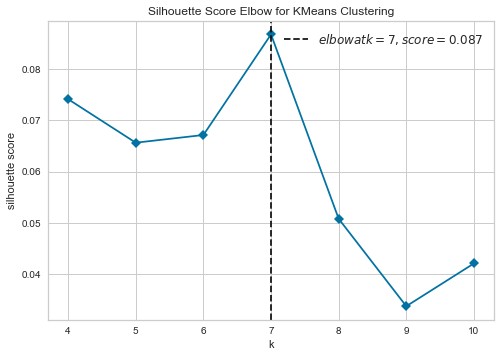

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [144]:
london_part_clustering = london_grouped.drop('neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(4,11), metric='silhouette', timings=False)

visualizer.fit(london_part_clustering)        # Fit the data to the visualizer
visualizer.poof()   

In [145]:
# set number of clusters
kclusters = 6

london_grouped_clustering = london_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 1, 4, 3, 3, 4, 4, 3, 4])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

Before the merge let's check if both tables have all the same neighborhoods

In [146]:
london_central.loc[~london_central['neighborhood'].isin(london_central['neighborhood'])]

,sub_region,sub_region_encoded,borough,neighborhood,latitude,longitude


In [147]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)

london_merged = london_central.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.iloc[:, 3:].join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood', how='inner')

london_merged.head() # check the last columns!
london_merged.shape

(95, 14)

In [148]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['latitude'], london_merged['longitude'], london_merged['neighborhood'], london_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [149]:
london_merged.loc[london_merged['cluster_labels'] == 0, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,51.574432,Bakery,Indian Restaurant,Gastropub,Pool,Plaza,Café,Event Space,Exhibit
26,51.482096,Garden,French Restaurant,Bar,Farmers Market,English Restaurant,Plaza,Café,Gym / Fitness Center
66,51.453517,Grocery Store,Convenience Store,Park,Fish & Chips Shop,Post Office,Hotel,Falafel Restaurant,English Restaurant
70,51.462265,Garden Center,Food,Flower Shop,Ethiopian Restaurant,Food & Drink Shop,Event Space,Exhibit,Fabric Shop


#### Cluster 2

In [150]:
london_merged.loc[london_merged['cluster_labels'] == 1, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,51.511828,Coffee Shop,Restaurant,Building,Cocktail Bar,Scenic Lookout,History Museum,Sandwich Place,Japanese Restaurant
34,51.531842,Gym / Fitness Center,Café,Burger Joint,Mexican Restaurant,Mediterranean Restaurant,Arts & Crafts Store,Vietnamese Restaurant,French Restaurant
38,51.523727,Café,Hotel,Pizza Place,Bar,Gym / Fitness Center,Italian Restaurant,French Restaurant,Food Truck
40,51.519823,Hotel,Beer Bar,Food Truck,Wine Bar,French Restaurant,Gym / Fitness Center,Italian Restaurant,Vietnamese Restaurant
41,51.526574,Sandwich Place,Café,Bar,Park,Pizza Place,Hotel,Restaurant,French Restaurant
56,51.463439,Cocktail Bar,Coffee Shop,Department Store,New American Restaurant,Brewery,Fast Food Restaurant,Street Art,Sandwich Place
60,51.427028,Park,Pub,Ice Cream Shop,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop
62,51.498686,Brewery,Italian Restaurant,Park,Bakery,Bar,Food Truck,French Restaurant,Tapas Restaurant
69,51.485289,Brewery,Fish & Chips Shop,Bike Rental / Bike Share,Falafel Restaurant,Theater,Bakery,Bagel Shop,Park
71,51.471490,Bar,Indie Movie Theater,Supermarket,Restaurant,Cocktail Bar,Gym / Fitness Center,Bus Stop,Hotel


#### Cluster 3

In [151]:
london_merged.loc[london_merged['cluster_labels'] == 2, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
65,51.435544,Ethiopian Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
74,51.432604,Pub,Cycle Studio,Filipino Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm


#### Cluster 4

In [152]:
london_merged.loc[london_merged['cluster_labels'] == 3, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,51.518533,Japanese Restaurant,Cocktail Bar,Clothing Store,Restaurant,Café,Juice Bar,French Restaurant,Hotel
13,51.532395,Café,Pub,Burger Joint,Art Gallery,Plaza,Breakfast Spot,Modern European Restaurant,Pizza Place
16,51.515472,Lounge,Bakery,Hotel,Pizza Place,Cocktail Bar,Bookstore,Tea Room,Sushi Restaurant
17,51.532291,Café,Breakfast Spot,Restaurant,Bar,Train Station,Gastropub,Sandwich Place,Italian Restaurant
18,51.542510,Grocery Store,Café,Bakery,Chinese Restaurant,Hotel Bar,Japanese Restaurant,Hotel,Pharmacy
21,51.514885,Gym / Fitness Center,Cocktail Bar,Café,Italian Restaurant,Wine Bar,Sushi Restaurant,Restaurant,Middle Eastern Restaurant
22,51.519660,Hotel,Café,Italian Restaurant,Gym / Fitness Center,French Restaurant,Sandwich Place,Gastropub,Turkish Restaurant
23,51.510767,Pub,Gym / Fitness Center,Hotel,Theater,Scenic Lookout,Wine Bar,Cocktail Bar,Bar
25,51.491822,Italian Restaurant,Garden,Burger Joint,Sandwich Place,Ice Cream Shop,Tapas Restaurant,Café,Pizza Place
27,51.490653,Café,Pizza Place,Grocery Store,Thai Restaurant,Garden,Historic Site,Lebanese Restaurant,Coffee Shop


#### Cluster 5

In [153]:
london_merged.loc[london_merged['cluster_labels'] == 4, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,51.545049,Italian Restaurant,Hotel Bar,Hotel,Deli / Bodega,Fish & Chips Shop,Brazilian Restaurant,Breakfast Spot,Coffee Shop
1,51.523126,Hotel,Bookstore,Pub,Garden,Park,Plaza,Exhibit,Bed & Breakfast
2,51.544548,Park,Garden Center,Bus Stop,Caribbean Restaurant,Beer Bar,Grocery Store,Coffee Shop,Pet Store
3,51.543969,Pub,Italian Restaurant,Coffee Shop,Pizza Place,Bakery,French Restaurant,Restaurant,Clothing Store
4,51.554879,Fast Food Restaurant,Hotel,Coffee Shop,Pub,Afghan Restaurant,Italian Restaurant,Sandwich Place,Café
6,51.552596,Pub,Spanish Restaurant,Restaurant,Grocery Store,BBQ Joint,Bagel Shop,Tennis Court,English Restaurant
7,51.553764,Train Station,Café,French Restaurant,Farm,Ethiopian Restaurant,Gastropub,Beer Store,Cocktail Bar
8,51.554215,Pub,Pizza Place,Ice Cream Shop,Italian Restaurant,Gym / Fitness Center,Bed & Breakfast,Thai Restaurant,Tapas Restaurant
10,51.517934,Hotel,Coffee Shop,Bookstore,Korean Restaurant,Café,Chinese Restaurant,Park,Japanese Restaurant
11,51.544777,Ice Cream Shop,Coffee Shop,Market,Bar,Art Gallery,Flea Market,Pizza Place,Speakeasy


#### Cluster 6

In [154]:
london_merged.loc[london_merged['cluster_labels'] == 5, london_merged.columns[[1] + list(range(6, london_merged.shape[1]))]]

,latitude,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,51.427492,Jazz Club,Bus Stop,Tea Room,Bar,Zoo Exhibit,Filipino Restaurant,Fabric Shop,Falafel Restaurant


## Comparison

#### Most common venues in NYC

In [ ]:
:fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = ['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
# fig.savefig('most-common-ven-nyc.png', dpi=300)